# VAE Volatility Surface Experiments

This notebook provides a clean workflow for:
1. Loading processed volatility surface data
2. Training VAE models (grid-wise and pointwise)
3. Evaluating surface completion with masking (0%, 25%, 50%, 75%)
4. Visualizing reconstructions

In [1]:
# Imports
import sys
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import matplotlib.pyplot as plt

# Project imports
from src.data.dataloaders import create_dataloaders
from src.models import MLPVAE, PointwiseMLPVAE, vae_loss
from src.utils import (
    fit_vae,
    evaluate_vae,
    evaluate_completion_sweep,
    print_completion_summary,
    create_random_mask,
)

## 1. Configuration

In [2]:
# Paths
PARQUET_PATH = Path("../Data/processed/parquet/AAPL_vsurf_processed.parquet")
CHECKPOINT_DIR = Path("../artifacts/train")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Model configuration
GRID_SHAPE = (2, 11, 17)  # (channels, maturities, deltas)
INPUT_DIM = np.prod(GRID_SHAPE)  # 330
LATENT_DIM = 8
HIDDEN_DIMS = [256, 128]

# Training configuration
BATCH_SIZE = 32
EPOCHS = 1000
LR = 1e-3
BETA = 1.0  # KL weight
PATIENCE = 100  # Early stopping

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Load Data

In [3]:
# Create dataloaders (chronological split, normalized)
bundle = create_dataloaders(
    parquet_path=PARQUET_PATH,
    value_col="impl_volatility",
    train_ratio=0.80,
    val_ratio=0.10,
    batch_size=BATCH_SIZE,
    normalize=True,
    return_date=True,  # Return (x, date) tuples
)

print(f"Train: {len(bundle.train_loader.dataset)} samples")
print(f"Val:   {len(bundle.val_loader.dataset)} samples")
print(f"Test:  {len(bundle.test_loader.dataset)} samples")

# Check a batch shape
batch = next(iter(bundle.train_loader))
x, date = batch
print(f"Batch shape: {x.shape}")

Train: 1943 samples
Val:   242 samples
Test:  244 samples
Batch shape: torch.Size([32, 2, 11, 17])


## 3. Define Model

In [4]:
# Use actual shape from loaded data (not hardcoded)
GRID_SHAPE = bundle.input_shape
print(f"Grid shape from data: {GRID_SHAPE} = {np.prod(GRID_SHAPE)} values")

# Grid-wise VAE
model = MLPVAE(
    in_shape=GRID_SHAPE,
    hidden_dims=HIDDEN_DIMS,
    latent_dim=LATENT_DIM,
).to(DEVICE)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Grid shape from data: (2, 11, 17) = 374 values
MLPVAE(
  (encoder): Sequential(
    (0): Linear(in_features=374, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=374, bias=True)
  )
)

Total parameters: 261,254


## 4. Train Model

In [5]:
# Train with early stopping
history = fit_vae(
    model=model,
    train_loader=bundle.train_loader,
    val_loader=bundle.val_loader,
    epochs=EPOCHS,
    lr=LR,
    beta=BETA,
    device=DEVICE,
    patience=PATIENCE,
    checkpoint_dir=CHECKPOINT_DIR,  # Directory, not file path
)

train:   0%|          | 0/61 [00:00<?, ?it/s]c:\Users\Admin\OneDrive\Desktop\Fifth Year\Computer Science\CS4490 Thesis\Codebase\Thesis\src\utils\training.py:101: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  total += float(loss) * bs


Epoch 001 | train: 0.758823 (recon 0.688053, kl 0.070770) | val: 0.398081 (recon 0.224268, kl 0.173812) *


Epoch 002 | train: 0.421822 (recon 0.272582, kl 0.149240) | val: 0.339497 (recon 0.249842, kl 0.089655) *


Epoch 003 | train: 0.365373 (recon 0.221680, kl 0.143692) | val: 0.314258 (recon 0.185330, kl 0.128928) *


Epoch 004 | train: 0.351644 (recon 0.209308, kl 0.142336) | val: 0.364222 (recon 0.284884, kl 0.079338)


Epoch 005 | train: 0.354605 (recon 0.214932, kl 0.139673) | val: 0.318749 (recon 0.193824, kl 0.124924)


Epoch 006 | train: 0.352118 (recon 0.205186, kl 0.146932) | val: 0.306703 (recon 0.190704, kl 0.115999) *


Epoch 007 | train: 0.345295 (recon 0.201283, kl 0.144011) | val: 0.303125 (recon 0.188044, kl 0.115080) *


Epoch 008 | train: 0.343339 (recon 0.198447, kl 0.144893) | val: 0.306400 (recon 0.211869, kl 0.094531)


Epoch 009 | train: 0.339975 (recon 0.200256, kl 0.139719) | val: 0.295337 (recon 0.176625, kl 0.118712) *


Epoch 010 | train: 0.340427 (recon 0.199394, kl 0.141033) | val: 0.339881 (recon 0.170267, kl 0.169615)


Epoch 011 | train: 0.344383 (recon 0.197498, kl 0.146885) | val: 0.305507 (recon 0.184239, kl 0.121268)


Epoch 012 | train: 0.337839 (recon 0.197009, kl 0.140830) | val: 0.286708 (recon 0.170604, kl 0.116104) *


Epoch 013 | train: 0.339696 (recon 0.196252, kl 0.143444) | val: 0.301957 (recon 0.201089, kl 0.100868)


Epoch 014 | train: 0.338110 (recon 0.195838, kl 0.142272) | val: 0.319677 (recon 0.182830, kl 0.136847)


Epoch 015 | train: 0.343544 (recon 0.198002, kl 0.145541) | val: 0.306045 (recon 0.192811, kl 0.113234)


Epoch 016 | train: 0.342173 (recon 0.199603, kl 0.142571) | val: 0.309851 (recon 0.190680, kl 0.119170)


Epoch 017 | train: 0.344158 (recon 0.198092, kl 0.146066) | val: 0.322479 (recon 0.223612, kl 0.098867)


Epoch 018 | train: 0.335980 (recon 0.194709, kl 0.141270) | val: 0.299610 (recon 0.212885, kl 0.086726)


Epoch 019 | train: 0.338158 (recon 0.198680, kl 0.139478) | val: 0.303424 (recon 0.189957, kl 0.113466)


Epoch 020 | train: 0.342933 (recon 0.197572, kl 0.145361) | val: 0.300485 (recon 0.206880, kl 0.093605)


Epoch 021 | train: 0.336119 (recon 0.192628, kl 0.143491) | val: 0.299248 (recon 0.222256, kl 0.076993)


Epoch 022 | train: 0.336432 (recon 0.191888, kl 0.144544) | val: 0.319225 (recon 0.201220, kl 0.118006)


Epoch 023 | train: 0.337853 (recon 0.192352, kl 0.145501) | val: 0.290150 (recon 0.208272, kl 0.081878)


Epoch 024 | train: 0.339815 (recon 0.194097, kl 0.145718) | val: 0.300522 (recon 0.201654, kl 0.098868)


Epoch 025 | train: 0.334568 (recon 0.193972, kl 0.140596) | val: 0.296629 (recon 0.185231, kl 0.111399)


Epoch 026 | train: 0.336496 (recon 0.189431, kl 0.147065) | val: 0.299320 (recon 0.217993, kl 0.081327)


Epoch 027 | train: 0.340854 (recon 0.194711, kl 0.146142) | val: 0.333095 (recon 0.244891, kl 0.088204)


Epoch 028 | train: 0.335342 (recon 0.190740, kl 0.144601) | val: 0.307683 (recon 0.209635, kl 0.098048)


Epoch 029 | train: 0.334077 (recon 0.186395, kl 0.147682) | val: 0.304272 (recon 0.201435, kl 0.102837)


Epoch 030 | train: 0.330428 (recon 0.189445, kl 0.140983) | val: 0.303547 (recon 0.199203, kl 0.104343)


Epoch 031 | train: 0.334469 (recon 0.190692, kl 0.143776) | val: 0.299148 (recon 0.186980, kl 0.112169)


Epoch 032 | train: 0.335580 (recon 0.183686, kl 0.151894) | val: 0.288058 (recon 0.184657, kl 0.103401)


Epoch 033 | train: 0.324955 (recon 0.184214, kl 0.140740) | val: 0.305277 (recon 0.191699, kl 0.113578)


Epoch 034 | train: 0.337610 (recon 0.190292, kl 0.147318) | val: 0.308112 (recon 0.184189, kl 0.123924)


Epoch 035 | train: 0.328953 (recon 0.184491, kl 0.144461) | val: 0.310105 (recon 0.188389, kl 0.121716)


Epoch 036 | train: 0.336671 (recon 0.187562, kl 0.149109) | val: 0.305505 (recon 0.204087, kl 0.101418)


Epoch 037 | train: 0.334557 (recon 0.190486, kl 0.144071) | val: 0.312710 (recon 0.179284, kl 0.133426)


Epoch 038 | train: 0.332496 (recon 0.186832, kl 0.145664) | val: 0.281274 (recon 0.180824, kl 0.100450) *


Epoch 039 | train: 0.333034 (recon 0.187397, kl 0.145637) | val: 0.291545 (recon 0.179507, kl 0.112038)


Epoch 040 | train: 0.335616 (recon 0.185364, kl 0.150252) | val: 0.300399 (recon 0.195222, kl 0.105177)


Epoch 041 | train: 0.327012 (recon 0.183783, kl 0.143228) | val: 0.314773 (recon 0.171943, kl 0.142830)


Epoch 042 | train: 0.336645 (recon 0.185182, kl 0.151463) | val: 0.291402 (recon 0.172298, kl 0.119104)


Epoch 043 | train: 0.329523 (recon 0.184287, kl 0.145236) | val: 0.295753 (recon 0.195325, kl 0.100428)


Epoch 044 | train: 0.332818 (recon 0.183437, kl 0.149381) | val: 0.293054 (recon 0.182449, kl 0.110605)


Epoch 045 | train: 0.331714 (recon 0.184898, kl 0.146817) | val: 0.297761 (recon 0.192246, kl 0.105515)


Epoch 046 | train: 0.328850 (recon 0.181810, kl 0.147040) | val: 0.306858 (recon 0.183299, kl 0.123559)


Epoch 047 | train: 0.331902 (recon 0.184642, kl 0.147260) | val: 0.311846 (recon 0.201964, kl 0.109882)


Epoch 048 | train: 0.324120 (recon 0.184332, kl 0.139789) | val: 0.290889 (recon 0.197348, kl 0.093540)


Epoch 049 | train: 0.333914 (recon 0.183638, kl 0.150276) | val: 0.303954 (recon 0.176362, kl 0.127592)


Epoch 050 | train: 0.328193 (recon 0.182603, kl 0.145590) | val: 0.305796 (recon 0.177793, kl 0.128003)


Epoch 051 | train: 0.331952 (recon 0.184233, kl 0.147719) | val: 0.302010 (recon 0.198716, kl 0.103294)


Epoch 052 | train: 0.335742 (recon 0.188272, kl 0.147470) | val: 0.304071 (recon 0.195754, kl 0.108317)


Epoch 053 | train: 0.332225 (recon 0.184233, kl 0.147993) | val: 0.297973 (recon 0.178017, kl 0.119956)


Epoch 054 | train: 0.335759 (recon 0.189282, kl 0.146477) | val: 0.298404 (recon 0.185365, kl 0.113039)


Epoch 055 | train: 0.328582 (recon 0.185038, kl 0.143545) | val: 0.295781 (recon 0.167582, kl 0.128199)


Epoch 056 | train: 0.330927 (recon 0.182630, kl 0.148296) | val: 0.311146 (recon 0.198658, kl 0.112489)


Epoch 057 | train: 0.331569 (recon 0.184879, kl 0.146690) | val: 0.317508 (recon 0.206599, kl 0.110908)


Epoch 058 | train: 0.325844 (recon 0.179683, kl 0.146161) | val: 0.311612 (recon 0.213442, kl 0.098171)


Epoch 059 | train: 0.328542 (recon 0.183414, kl 0.145128) | val: 0.296736 (recon 0.201590, kl 0.095146)


Epoch 060 | train: 0.329133 (recon 0.184501, kl 0.144632) | val: 0.294502 (recon 0.209719, kl 0.084782)


Epoch 061 | train: 0.329388 (recon 0.184616, kl 0.144772) | val: 0.297516 (recon 0.177643, kl 0.119873)


Epoch 062 | train: 0.329319 (recon 0.179075, kl 0.150243) | val: 0.296216 (recon 0.186439, kl 0.109777)


Epoch 063 | train: 0.327111 (recon 0.184457, kl 0.142654) | val: 0.298268 (recon 0.185490, kl 0.112778)


Epoch 064 | train: 0.331387 (recon 0.185197, kl 0.146190) | val: 0.294058 (recon 0.185913, kl 0.108144)


Epoch 065 | train: 0.329278 (recon 0.182305, kl 0.146973) | val: 0.288061 (recon 0.187959, kl 0.100101)


Epoch 066 | train: 0.329705 (recon 0.181230, kl 0.148475) | val: 0.298087 (recon 0.196367, kl 0.101719)


Epoch 067 | train: 0.331444 (recon 0.185243, kl 0.146201) | val: 0.300649 (recon 0.188694, kl 0.111954)


Epoch 068 | train: 0.329273 (recon 0.182981, kl 0.146292) | val: 0.292670 (recon 0.187980, kl 0.104690)


Epoch 069 | train: 0.329079 (recon 0.182810, kl 0.146270) | val: 0.304879 (recon 0.211466, kl 0.093413)


Epoch 070 | train: 0.325620 (recon 0.181879, kl 0.143741) | val: 0.300467 (recon 0.178479, kl 0.121988)


Epoch 071 | train: 0.325225 (recon 0.178862, kl 0.146363) | val: 0.305853 (recon 0.203482, kl 0.102371)


Epoch 072 | train: 0.323627 (recon 0.180127, kl 0.143501) | val: 0.295572 (recon 0.196069, kl 0.099503)


Epoch 073 | train: 0.325667 (recon 0.182411, kl 0.143256) | val: 0.301848 (recon 0.192532, kl 0.109316)


Epoch 074 | train: 0.325147 (recon 0.180705, kl 0.144442) | val: 0.282360 (recon 0.195827, kl 0.086533)


Epoch 075 | train: 0.330592 (recon 0.183956, kl 0.146637) | val: 0.303738 (recon 0.192408, kl 0.111329)


Epoch 076 | train: 0.324526 (recon 0.180437, kl 0.144090) | val: 0.291210 (recon 0.203512, kl 0.087697)


Epoch 077 | train: 0.327227 (recon 0.182178, kl 0.145049) | val: 0.297554 (recon 0.183441, kl 0.114113)


Epoch 078 | train: 0.328061 (recon 0.180194, kl 0.147867) | val: 0.302128 (recon 0.191831, kl 0.110297)


Epoch 079 | train: 0.327271 (recon 0.181210, kl 0.146061) | val: 0.314430 (recon 0.190746, kl 0.123684)


Epoch 080 | train: 0.332575 (recon 0.184116, kl 0.148459) | val: 0.296092 (recon 0.199466, kl 0.096627)


Epoch 081 | train: 0.325603 (recon 0.182555, kl 0.143049) | val: 0.306144 (recon 0.213430, kl 0.092713)


Epoch 082 | train: 0.324234 (recon 0.180351, kl 0.143882) | val: 0.300180 (recon 0.193498, kl 0.106682)


Epoch 083 | train: 0.331400 (recon 0.181266, kl 0.150134) | val: 0.297391 (recon 0.194004, kl 0.103387)


Epoch 084 | train: 0.327291 (recon 0.181178, kl 0.146112) | val: 0.297211 (recon 0.189193, kl 0.108018)


Epoch 085 | train: 0.324897 (recon 0.180428, kl 0.144468) | val: 0.289434 (recon 0.193662, kl 0.095772)


Epoch 086 | train: 0.325629 (recon 0.176982, kl 0.148647) | val: 0.297451 (recon 0.185639, kl 0.111812)


Epoch 087 | train: 0.323066 (recon 0.177590, kl 0.145476) | val: 0.303650 (recon 0.212285, kl 0.091366)


Epoch 088 | train: 0.324049 (recon 0.178117, kl 0.145933) | val: 0.295386 (recon 0.182855, kl 0.112532)


Epoch 089 | train: 0.326087 (recon 0.178392, kl 0.147695) | val: 0.294132 (recon 0.191399, kl 0.102732)


Epoch 090 | train: 0.321847 (recon 0.179378, kl 0.142469) | val: 0.299113 (recon 0.183638, kl 0.115475)


Epoch 091 | train: 0.324339 (recon 0.178557, kl 0.145782) | val: 0.313655 (recon 0.211690, kl 0.101965)


Epoch 092 | train: 0.323311 (recon 0.176890, kl 0.146420) | val: 0.298001 (recon 0.196589, kl 0.101413)


Epoch 093 | train: 0.337025 (recon 0.186164, kl 0.150861) | val: 0.298545 (recon 0.180884, kl 0.117661)


Epoch 094 | train: 0.328323 (recon 0.181064, kl 0.147260) | val: 0.302277 (recon 0.174284, kl 0.127993)


Epoch 095 | train: 0.326488 (recon 0.176270, kl 0.150218) | val: 0.296686 (recon 0.185647, kl 0.111039)


Epoch 096 | train: 0.327904 (recon 0.180462, kl 0.147443) | val: 0.289063 (recon 0.182464, kl 0.106599)


Epoch 097 | train: 0.326474 (recon 0.177866, kl 0.148609) | val: 0.304242 (recon 0.201777, kl 0.102465)


Epoch 098 | train: 0.326456 (recon 0.178076, kl 0.148380) | val: 0.289277 (recon 0.195335, kl 0.093943)


Epoch 099 | train: 0.320822 (recon 0.178828, kl 0.141994) | val: 0.281456 (recon 0.179039, kl 0.102417)


Epoch 100 | train: 0.325566 (recon 0.176189, kl 0.149376) | val: 0.304875 (recon 0.197817, kl 0.107059)


Epoch 101 | train: 0.320492 (recon 0.178475, kl 0.142017) | val: 0.296178 (recon 0.193345, kl 0.102833)


Epoch 102 | train: 0.325852 (recon 0.176528, kl 0.149324) | val: 0.293691 (recon 0.184559, kl 0.109132)


Epoch 103 | train: 0.322366 (recon 0.180085, kl 0.142281) | val: 0.294484 (recon 0.190844, kl 0.103639)


Epoch 104 | train: 0.325210 (recon 0.176836, kl 0.148374) | val: 0.306789 (recon 0.195279, kl 0.111510)


Epoch 105 | train: 0.322954 (recon 0.177770, kl 0.145184) | val: 0.292170 (recon 0.192113, kl 0.100058)


Epoch 106 | train: 0.323413 (recon 0.175254, kl 0.148160) | val: 0.281446 (recon 0.187511, kl 0.093935)


Epoch 107 | train: 0.327742 (recon 0.178861, kl 0.148881) | val: 0.293771 (recon 0.181007, kl 0.112765)


Epoch 108 | train: 0.323507 (recon 0.178576, kl 0.144931) | val: 0.295307 (recon 0.182143, kl 0.113164)


Epoch 109 | train: 0.323927 (recon 0.176179, kl 0.147747) | val: 0.301349 (recon 0.194701, kl 0.106648)


Epoch 110 | train: 0.326063 (recon 0.179435, kl 0.146628) | val: 0.296678 (recon 0.197534, kl 0.099144)


Epoch 111 | train: 0.323409 (recon 0.178498, kl 0.144911) | val: 0.302977 (recon 0.202213, kl 0.100763)


Epoch 112 | train: 0.323338 (recon 0.174652, kl 0.148687) | val: 0.282117 (recon 0.181112, kl 0.101004)


Epoch 113 | train: 0.328071 (recon 0.181395, kl 0.146677) | val: 0.295900 (recon 0.197518, kl 0.098381)


Epoch 114 | train: 0.326746 (recon 0.178273, kl 0.148472) | val: 0.303731 (recon 0.201247, kl 0.102484)


Epoch 115 | train: 0.325015 (recon 0.178633, kl 0.146381) | val: 0.290620 (recon 0.192539, kl 0.098081)


Epoch 116 | train: 0.318835 (recon 0.173161, kl 0.145674) | val: 0.300879 (recon 0.212294, kl 0.088585)


Epoch 117 | train: 0.323382 (recon 0.178025, kl 0.145357) | val: 0.291128 (recon 0.185007, kl 0.106120)


Epoch 118 | train: 0.320730 (recon 0.175147, kl 0.145583) | val: 0.289320 (recon 0.191864, kl 0.097456)


Epoch 119 | train: 0.325268 (recon 0.178683, kl 0.146585) | val: 0.291529 (recon 0.187977, kl 0.103552)


Epoch 120 | train: 0.323208 (recon 0.177252, kl 0.145956) | val: 0.287652 (recon 0.186253, kl 0.101398)


Epoch 121 | train: 0.325595 (recon 0.176330, kl 0.149265) | val: 0.296708 (recon 0.199642, kl 0.097065)


Epoch 122 | train: 0.325185 (recon 0.176345, kl 0.148841) | val: 0.288233 (recon 0.182464, kl 0.105769)


Epoch 123 | train: 0.321090 (recon 0.176631, kl 0.144459) | val: 0.282598 (recon 0.186963, kl 0.095635)


Epoch 124 | train: 0.323017 (recon 0.174945, kl 0.148072) | val: 0.302596 (recon 0.194727, kl 0.107869)


Epoch 125 | train: 0.323804 (recon 0.176103, kl 0.147701) | val: 0.301300 (recon 0.199759, kl 0.101541)


Epoch 126 | train: 0.325680 (recon 0.177780, kl 0.147900) | val: 0.299310 (recon 0.201415, kl 0.097895)


Epoch 127 | train: 0.327510 (recon 0.178856, kl 0.148653) | val: 0.288233 (recon 0.179695, kl 0.108538)


Epoch 128 | train: 0.324050 (recon 0.172834, kl 0.151216) | val: 0.286498 (recon 0.186028, kl 0.100470)


Epoch 129 | train: 0.322812 (recon 0.178144, kl 0.144668) | val: 0.302742 (recon 0.207350, kl 0.095392)


Epoch 130 | train: 0.321810 (recon 0.175534, kl 0.146276) | val: 0.292811 (recon 0.186579, kl 0.106231)


Epoch 131 | train: 0.328995 (recon 0.180550, kl 0.148445) | val: 0.294966 (recon 0.173436, kl 0.121530)


Epoch 132 | train: 0.327894 (recon 0.176500, kl 0.151394) | val: 0.289105 (recon 0.184799, kl 0.104306)


Epoch 133 | train: 0.324757 (recon 0.177632, kl 0.147125) | val: 0.303871 (recon 0.195041, kl 0.108830)


Epoch 134 | train: 0.330656 (recon 0.179489, kl 0.151166) | val: 0.292208 (recon 0.186918, kl 0.105290)


Epoch 135 | train: 0.325031 (recon 0.176762, kl 0.148269) | val: 0.307893 (recon 0.199269, kl 0.108624)


Epoch 136 | train: 0.321537 (recon 0.174740, kl 0.146797) | val: 0.288006 (recon 0.188675, kl 0.099332)


Epoch 137 | train: 0.325943 (recon 0.178344, kl 0.147599) | val: 0.306089 (recon 0.190694, kl 0.115394)


Epoch 138 | train: 0.325376 (recon 0.176595, kl 0.148781) | val: 0.306362 (recon 0.203807, kl 0.102554)
Early stopping at epoch 138. Best epoch was 38 with val_loss=0.281274
Best model saved at epoch 38 with val_loss=0.281274


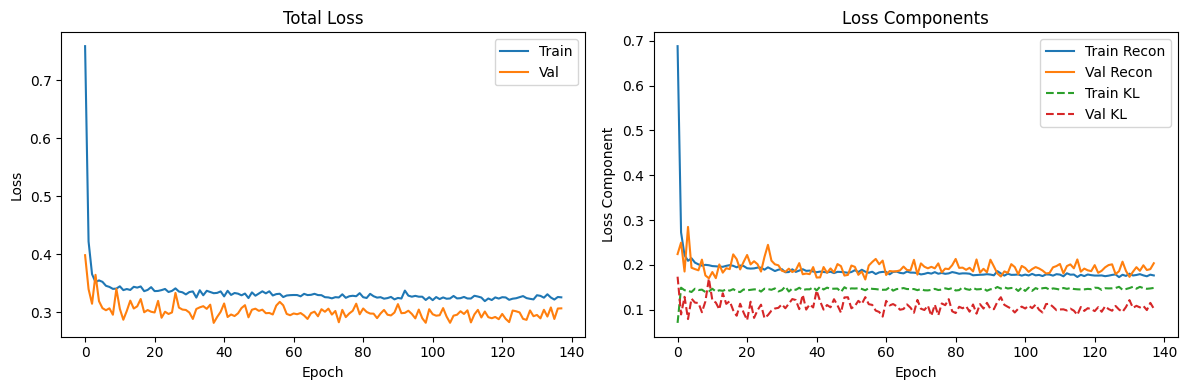

In [6]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# history is a list of TrainStats dataclasses
train_loss = [h.train_loss for h in history]
val_loss = [h.val_loss for h in history]
train_recon = [h.train_recon for h in history]
val_recon = [h.val_recon for h in history]
train_kl = [h.train_kl for h in history]
val_kl = [h.val_kl for h in history]

ax1.plot(train_loss, label='Train')
ax1.plot(val_loss, label='Val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Total Loss')
ax1.legend()

ax2.plot(train_recon, label='Train Recon')
ax2.plot(val_recon, label='Val Recon')
ax2.plot(train_kl, label='Train KL', linestyle='--')
ax2.plot(val_kl, label='Val KL', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss Component')
ax2.set_title('Loss Components')
ax2.legend()

plt.tight_layout()
plt.show()

## 5. Load Best Model & Evaluate

In [7]:
# Load best checkpoint
ckpt = torch.load(CHECKPOINT_DIR / "best_model.pt", map_location=DEVICE)
model.load_state_dict(ckpt['model_state_dict'])
print(f"Loaded best model from epoch {ckpt['epoch']}")
print(f"Best val loss: {ckpt['val_loss']:.6f}")

Loaded best model from epoch 38
Best val loss: 0.281274


In [8]:
# Standard evaluation on test set
metrics = evaluate_vae(model, bundle.test_loader, DEVICE)

print(f"\n=== Test Set Metrics ===")
print(f"MSE:  {metrics.mse:.6f}")
print(f"MAE:  {metrics.mae:.6f}")
print(f"RMSE: {metrics.rmse:.6f}")


=== Test Set Metrics ===
MSE:  0.179040
MAE:  0.289201
RMSE: 0.423131


## 6. Surface Completion Evaluation (Masking)

Following Bergeron et al., we evaluate the model's ability to complete partially observed surfaces.
We mask 0%, 25%, 50%, and 75% of the surface and measure reconstruction error on the masked points.

In [9]:
# Run masking evaluation
completion_results = evaluate_completion_sweep(
    model=model,
    loader=bundle.test_loader,
    grid_shape=GRID_SHAPE,
    device=DEVICE,
    mask_ratios=(0.0, 0.25, 0.50, 0.75, 0.90, 1),
    seed=42,
    scaler=bundle.scaler,
)

# Print summary table
print_completion_summary(completion_results)

Mask   0.0% | MAE masked: 0.000000 | MAE observed: 0.281692 | MAE full: 0.281692
Mask  25.0% | MAE masked: 0.326558 | MAE observed: 0.324455 | MAE full: 0.324978
Mask  50.0% | MAE masked: 0.391740 | MAE observed: 0.405832 | MAE full: 0.398786
Mask  75.0% | MAE masked: 0.499256 | MAE observed: 0.472105 | MAE full: 0.492432
Mask  90.0% | MAE masked: 0.537729 | MAE observed: 0.543577 | MAE full: 0.538323
Mask 100.0% | MAE masked: 0.600381 | MAE observed: 0.000000 | MAE full: 0.600381

SURFACE COMPLETION EVALUATION
  Mask % |   MSE Masked |   MAE Masked |  RMSE Masked
----------------------------------------------------------------------
    0.0% |     0.000000 |     0.000000 |     0.000000
   24.9% |     0.250731 |     0.326558 |     0.500730
   50.0% |     0.360321 |     0.391740 |     0.600267
   74.9% |     0.535083 |     0.499256 |     0.731494
   89.8% |     0.608229 |     0.537729 |     0.779890
  100.0% |     0.722919 |     0.600381 |     0.850246


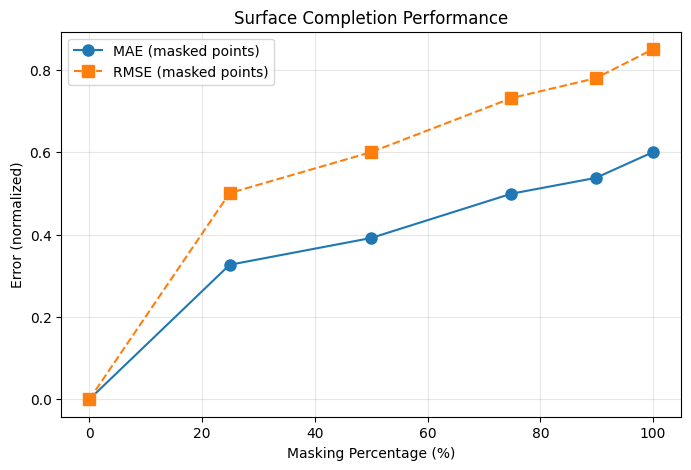

In [10]:
# Plot completion performance
ratios = [r.mask_ratio for r in completion_results]
maes = [r.mae_masked for r in completion_results]
rmses = [r.rmse_masked for r in completion_results]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot([r*100 for r in ratios], maes, 'o-', label='MAE (masked points)', markersize=8)
ax.plot([r*100 for r in ratios], rmses, 's--', label='RMSE (masked points)', markersize=8)
ax.set_xlabel('Masking Percentage (%)')
ax.set_ylabel('Error (normalized)')
ax.set_title('Surface Completion Performance')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 7. Visualize Reconstructions

In [11]:
def plot_surface_comparison(x_orig, x_recon, mask=None, title="Surface Comparison"):
    """Plot original vs reconstructed surface for one channel."""
    fig, axes = plt.subplots(1, 3 if mask is None else 4, figsize=(14, 4))
    
    # Original surface (channel 0 - Calls)
    im0 = axes[0].imshow(x_orig[0], aspect='auto', cmap='viridis')
    axes[0].set_title('Original (Calls)')
    axes[0].set_xlabel('Delta')
    axes[0].set_ylabel('Maturity')
    plt.colorbar(im0, ax=axes[0])
    
    # Reconstructed
    im1 = axes[1].imshow(x_recon[0], aspect='auto', cmap='viridis')
    axes[1].set_title('Reconstructed (Calls)')
    axes[1].set_xlabel('Delta')
    plt.colorbar(im1, ax=axes[1])
    
    # Error
    error = np.abs(x_orig[0] - x_recon[0])
    im2 = axes[2].imshow(error, aspect='auto', cmap='Reds')
    axes[2].set_title('Absolute Error')
    axes[2].set_xlabel('Delta')
    plt.colorbar(im2, ax=axes[2])
    
    if mask is not None:
        im3 = axes[3].imshow(mask[0], aspect='auto', cmap='gray')
        axes[3].set_title('Mask (1=hidden)')
        axes[3].set_xlabel('Delta')
        plt.colorbar(im3, ax=axes[3])
    
    fig.suptitle(title)
    plt.tight_layout()
    return fig

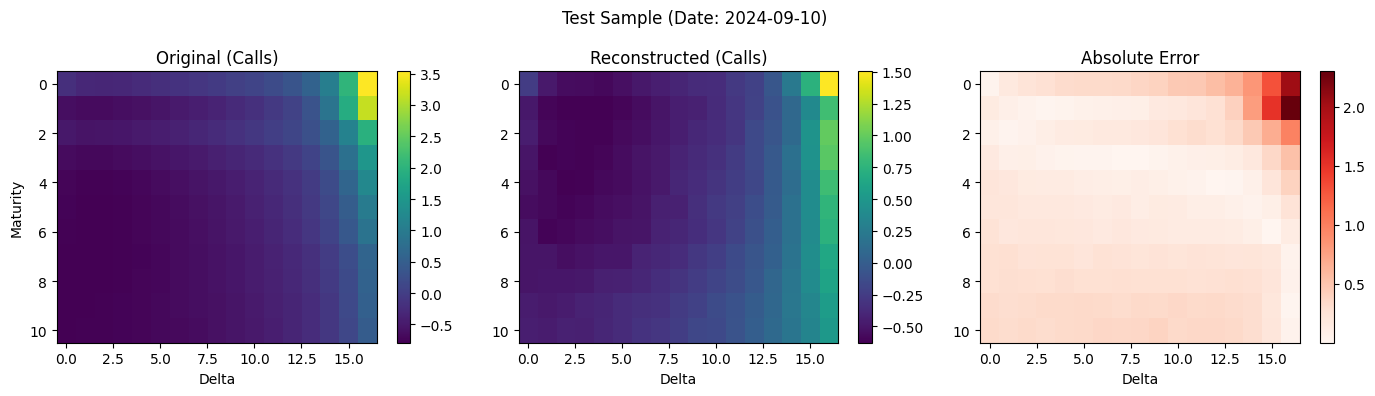

In [12]:
# Get a sample and reconstruct
model.eval()
with torch.no_grad():
    x, date = next(iter(bundle.test_loader))
    x = x.to(DEVICE)
    recon, mu, logvar = model(x)
    
    # Plot first sample
    idx = 0
    x_np = x[idx].cpu().numpy()
    recon_np = recon[idx].cpu().numpy()
    
    plot_surface_comparison(x_np, recon_np, title=f"Test Sample (Date: {date[idx]})")
    plt.show()

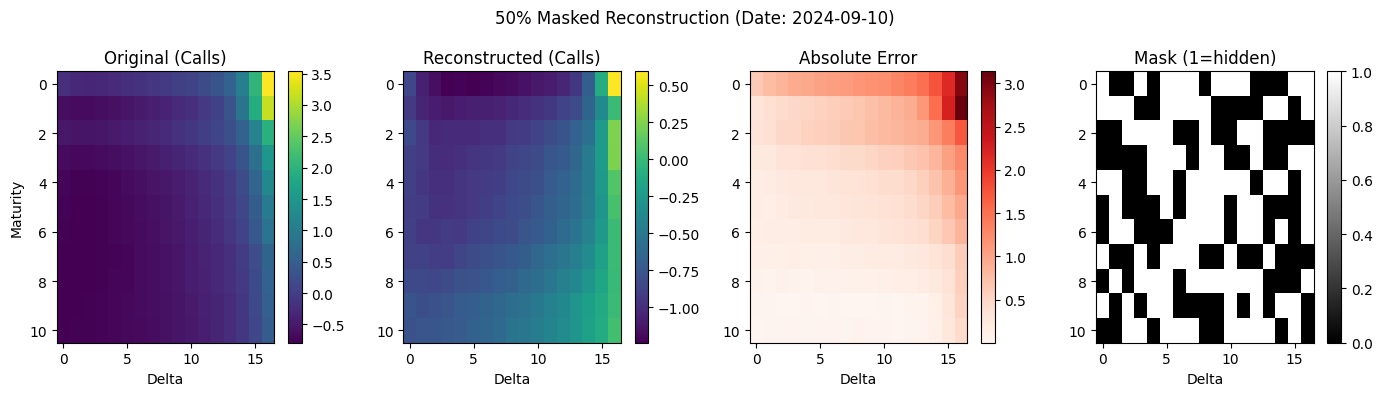

In [13]:
# Visualize masked reconstruction (50% mask)
mask = create_random_mask(GRID_SHAPE, mask_ratio=0.5, seed=42, device=DEVICE)

with torch.no_grad():
    x, date = next(iter(bundle.test_loader))
    x = x.to(DEVICE)
    
    # Apply mask
    x_masked = x * (1 - mask.unsqueeze(0))
    
    # Reconstruct from masked input
    recon, mu, logvar = model(x_masked)
    
    # Plot
    idx = 0
    plot_surface_comparison(
        x[idx].cpu().numpy(),
        recon[idx].cpu().numpy(),
        mask.cpu().numpy(),
        title=f"50% Masked Reconstruction (Date: {date[idx]})"
    )
    plt.show()

## 8. Latent Space Visualization

In [14]:
# Extract latent codes for all test samples
latent_codes = []
dates = []

model.eval()
with torch.no_grad():
    for batch in bundle.test_loader:
        x, d = batch
        x = x.to(DEVICE)
        mu, logvar = model.encode(x)
        latent_codes.append(mu.cpu().numpy())
        dates.extend(d)

latent_codes = np.concatenate(latent_codes, axis=0)
print(f"Latent codes shape: {latent_codes.shape}")

Latent codes shape: (244, 8)


PCA explained variance: 99.7%


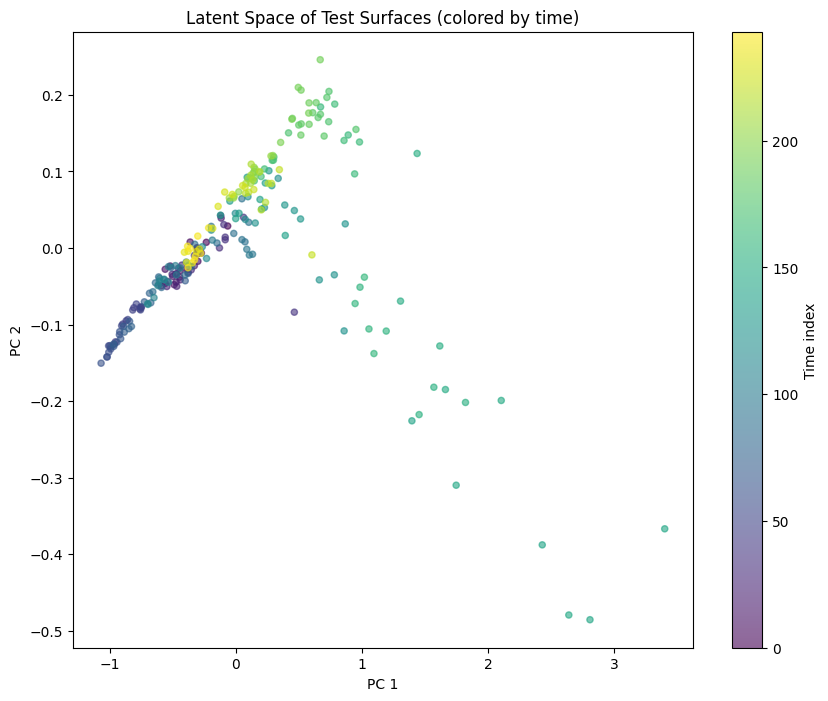

In [15]:
# PCA visualization (if latent_dim > 2)
from sklearn.decomposition import PCA

if LATENT_DIM > 2:
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_codes)
    print(f"PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")
else:
    latent_2d = latent_codes

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                       c=range(len(latent_2d)), cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Time index')
plt.xlabel('Latent Dim 1' if LATENT_DIM <= 2 else 'PC 1')
plt.ylabel('Latent Dim 2' if LATENT_DIM <= 2 else 'PC 2')
plt.title('Latent Space of Test Surfaces (colored by time)')
plt.show()